In [33]:
from keras import backend as K
import keras
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tqdm
from skimage.feature import ORB
from skimage.color import rgb2gray
import os
import random


# Load Data

In [46]:
X_train = np.load("./Data/Dataset/X_train.npy")
X_test = np.load("./Data/Dataset/X_test.npy")
X_validate = np.load("./Data/Dataset/X_validate.npy")

Y_train = np.load("./Data/Dataset/Y_train.npy")
Y_test = np.load("./Data/Dataset/Y_test.npy")
Y_validate = np.load("./Data/Dataset/Y_validate.npy")

print(X_train.shape, X_test.shape, X_validate.shape)

(28884, 2, 2560) (3611, 2, 2560) (3611, 2, 2560)


# Build Model

In [35]:
# Dimensions of the input vectors
input_dim =  X_train.shape[2]

# Define the Siamese network architecture
input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))

# Shared weights between the two networks
shared_dense_layer_1 = Dense(100, activation='sigmoid',kernel_regularizer=keras.regularizers.l2(0.001))
shared_dense_layer_2 = Dense(50, activation='sigmoid',kernel_regularizer=keras.regularizers.l2(0.001)) 
shared_dense_layer_3 = Dropout(0.2)
shared_dense_layer_4 = Dense(10, activation='sigmoid')


# Stacking the layers
encoded_a = shared_dense_layer_4(shared_dense_layer_3(shared_dense_layer_2(shared_dense_layer_1(input_a))))
encoded_b = shared_dense_layer_4(shared_dense_layer_3(shared_dense_layer_2(shared_dense_layer_1(input_b))))


# Define the Euclidean distance between the encoded vectors
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# Define the Cosine distance between the encoded vectors
def cosine_distance(vects):
    x, y = vects
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

distance = Lambda(euclidean_distance)([encoded_a, encoded_b])

# Output layer with a sigmoid activation function
prediction = Dense(1, activation='sigmoid')(distance)

# Define the Siamese model
model = Model(inputs=[input_a, input_b], outputs=prediction)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 2560)]               0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 2560)]               0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 100)                  256100    ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 50)                   5050      ['dense_8[0][0]',       

# Train the Model

In [36]:
# Train the model
history = model.fit([X_train[:, 0], X_train[:, 1]], Y_train, 
          validation_data=([X_validate[:, 0], X_validate[:, 1]], Y_validate), 
          batch_size=32, epochs=10)

Epoch 1/10
903/903 [==============================] - 3s 2ms/step - loss: 0.1269 - accuracy: 0.9092 - val_loss: 0.0645 - val_accuracy: 0.9950
Epoch 2/10
903/903 [==============================] - 2s 2ms/step - loss: 0.0514 - accuracy: 0.9964 - val_loss: 0.0347 - val_accuracy: 0.9950
Epoch 3/10
903/903 [==============================] - 2s 2ms/step - loss: 0.0313 - accuracy: 0.9965 - val_loss: 0.0245 - val_accuracy: 0.9950
Epoch 4/10
903/903 [==============================] - 2s 2ms/step - loss: 0.0217 - accuracy: 0.9974 - val_loss: 0.0198 - val_accuracy: 0.9950
Epoch 5/10
903/903 [==============================] - 2s 2ms/step - loss: 0.0205 - accuracy: 0.9964 - val_loss: 0.0222 - val_accuracy: 0.9950
Epoch 6/10
903/903 [==============================] - 2s 2ms/step - loss: 0.0185 - accuracy: 0.9964 - val_loss: 0.0299 - val_accuracy: 0.9950
Epoch 7/10
903/903 [==============================] - 2s 2ms/step - loss: 0.0184 - accuracy: 0.9959 - val_loss: 0.0170 - val_accuracy: 0.9950
Epoch 

In [25]:
if False:
    model.save('model_lite.h5')

### Plot History loss

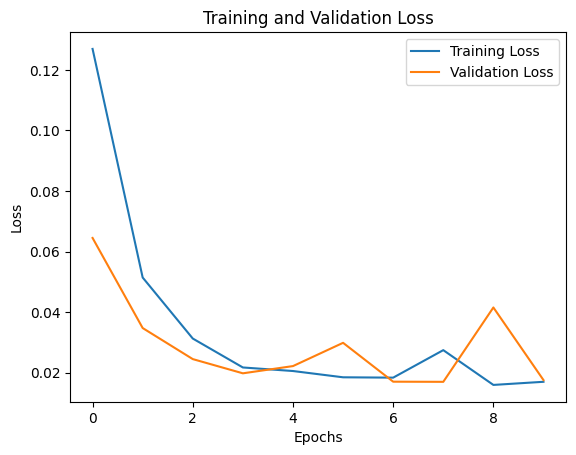

14500
(28884,)


In [37]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(np.count_nonzero(Y_train))
print(Y_train.shape)


# Evaluation of the Model

In [62]:

# prediction
y_pred = model.predict([X_test[:, 0], X_test[:, 1]])

# Define a custom function to calculate accuracy within a margin of error
def calculate_accuracy(y_true, y_pred, margin):
    correct_predictions = 0
    for true, pred in zip(y_true, y_pred):
        if abs(true - pred) < margin:
            correct_predictions += 1
    return correct_predictions / len(y_true)

# Set a margin of error
margin_of_error = 0.01  # Adjust as needed based on the tolerance level

# Calculate accuracy within the margin of error
accuracy_within_margin = calculate_accuracy(Y_test, y_pred.flatten(), margin_of_error)

# Display the calculated accuracy within the margin of error
print(f"Accuracy within a margin of {margin_of_error}: {accuracy_within_margin}")

113/113 [==============================] - 0s 1ms/step
Accuracy within a margin of 0.01: 0.5137081140958183


# Try the Model

In [39]:
# Load the model
#loaded_model = keras.models.load_model('my_siamese_model')


In [47]:
# map
with open("Data/database/database_lite.json","r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc=np.array(m_idx["loc"])

# query
with open("Data/query/query_lite.json","r") as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_loc=np.array(q_idx["loc"])

# loading the relevance judgements
with h5py.File("Data/london_lite_gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)


def load_dict(file_path):
    imgs = np.load(file_path+"img_path.npy")
    descriptors = np.load(file_path+"descriptors.npy")

    return dict(zip(imgs, descriptors))

img2vec = load_dict("./Data/Dataset/")

In [41]:

def get_descriptors(img_path, n_keypoints=10):
    
    # Initialize the ORB descriptor
    descriptor_extractor = ORB(n_keypoints=n_keypoints)

    #img = Image.open(os.path.join('data_image_retrieval/', img_name)).convert()
    #img = np.asarray(img)
    img = plt.imread(os.path.join('Data/', img_path))
    img = rgb2gray(img)

    # Extract ORB descriptors
    descriptor_extractor.detect_and_extract(img)

    descriptor = descriptor_extractor.descriptors  # descriptors (the feature vectors)

    return descriptor.reshape(-1)

In [42]:
def retrieve_images(query_image_path, n_images_to_retrieve, img2vec, m_imgs, model):
    # Process the query image and get its vector
    query_vector = get_descriptors(query_image_path,10)  # Replace with your image processing function

    
    # Initialize a list to store the relevance scores
    relevance_scores = []

    # Iterate through all the image paths in m_imgs
    for image_path in m_imgs:
        # Get the vector from the dictionary img2vec
        image_vector = img2vec[image_path]

        # Predict the relevance score using the model
        relevance_score = model.predict([np.array([query_vector]), np.array([image_vector])])[0][0]

        # Append the image path and relevance score to the list
        relevance_scores.append((image_path, relevance_score))
        
    # Sort the list of relevance scores by the score in descending order
    relevance_scores.sort(key=lambda x: x[1], reverse=True)

    # Return the top n_images_to_retrieve relevant image paths with their scores
    return relevance_scores[:n_images_to_retrieve]

In [43]:
test_image = q_imgs[461]
retrieved_images = retrieve_images(test_image,50,img2vec,m_imgs,model)

1/1 [==============================] - 0s 23ms/step


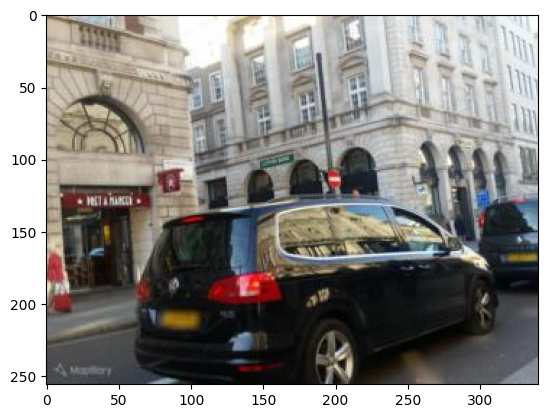

In [44]:
plt.imshow(plt.imread('Data/' + q_imgs[461]))

[('database/images/t9T8c7Pc-d6vf_u9UguDzQ.jpg', 0.9691317), ('database/images/gcb16fr5x-HCR_iEfuTchw.jpg', 0.9691317), ('database/images/uHCmk-DA9pA0STHI3zjsuA.jpg', 0.9691317), ('database/images/tm0vZJPCN1paQrEKH86w2g.jpg', 0.9691317), ('database/images/MVCshH6HTv0YcrNeyOfwCQ.jpg', 0.9691235), ('database/images/OUCMU-tLV_Mzr5OABfSNFQ.jpg', 0.96905196), ('database/images/W49w4u11la0k_VJ9uvyOfQ.jpg', 0.96902084), ('database/images/HtWTtR-9yGwd0B1h1uMq2g.jpg', 0.9690072), ('database/images/wtgivv8TfvotCQ_poKkXEg.jpg', 0.96899027), ('database/images/7b0cSB1dQmCI6fGlWfQTgw.jpg', 0.9689664)]


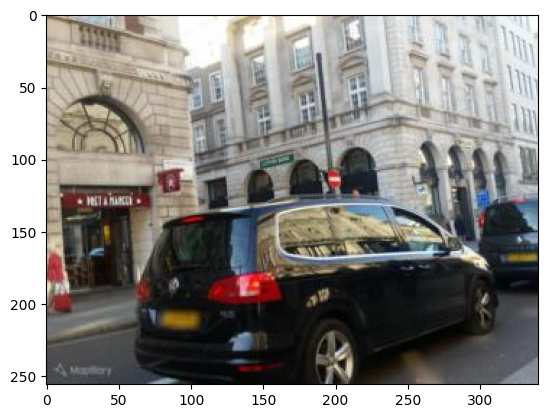

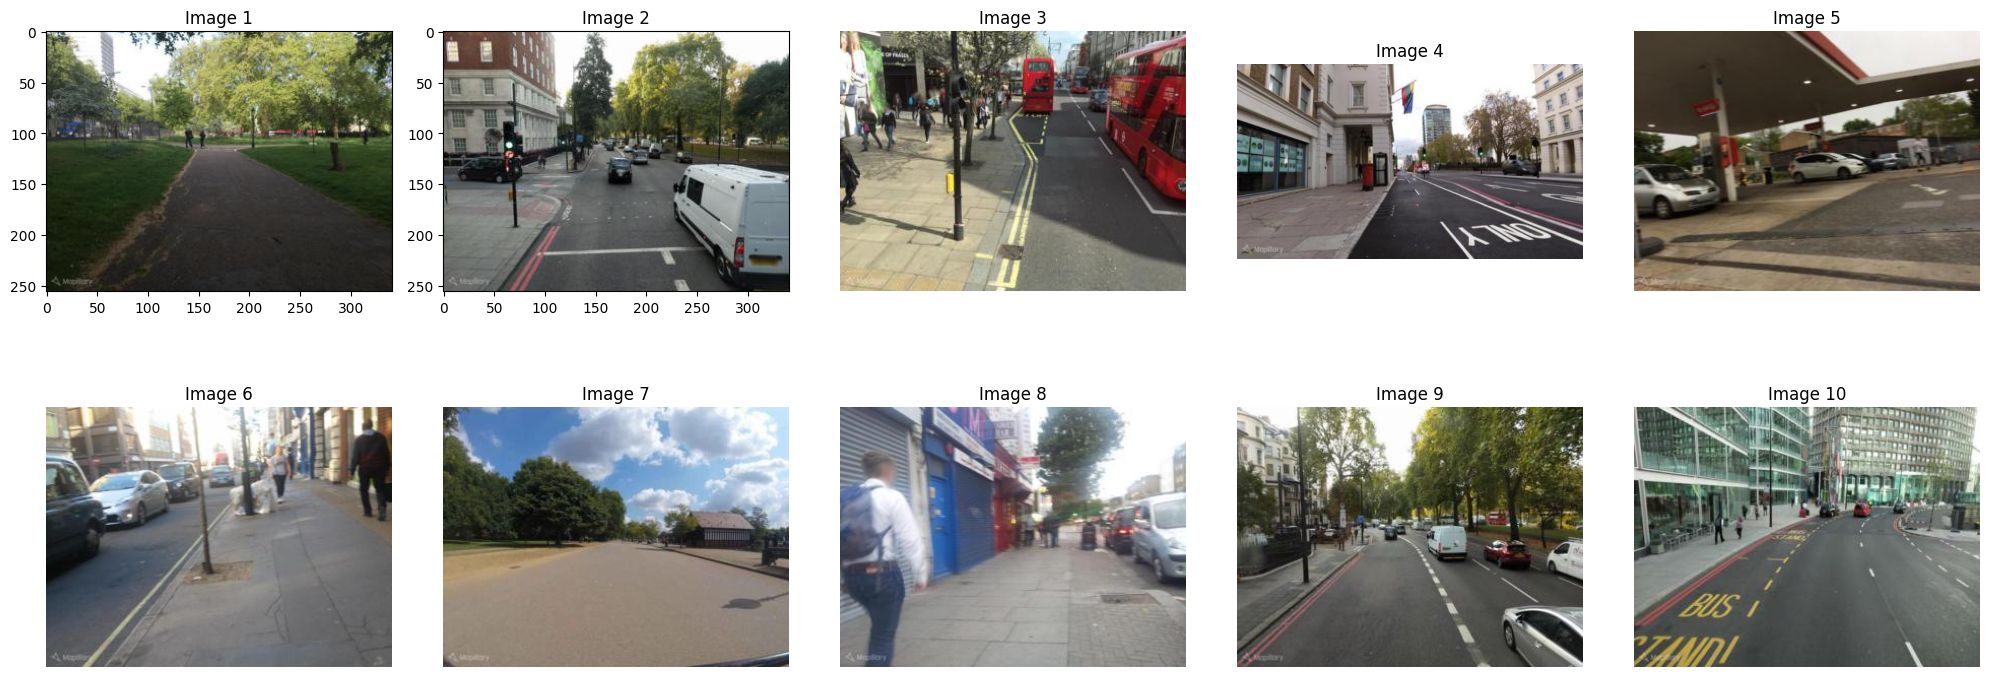

In [45]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


rt_img  = retrieved_images
retrieved_images = rt_img[:10]
print(retrieved_images)
# Assuming you have an array of image paths named image_paths
# image_paths = [...]  # Your array of image paths

# Define the number of rows and columns for subplots
nrows = 2
ncols = 5


plt.imshow(plt.imread('Data/' + test_image))

# Create a new figure and set the size
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))

# Loop through the image paths and plot the images
for i, image_path in enumerate(retrieved_images):
    # Read the image
    img = mpimg.imread('Data/'+image_path[0])

    # Determine the subplot index
    ax = axes[i // ncols, i % ncols]

    # Plot the image
    ax.imshow(img)
    ax.set_title(f'Image {i+1}')

# Hide any empty subplots
for i in range(len(image_path), nrows*ncols):
    ax = axes[i // ncols, i % ncols]
    ax.axis('off')

# Display the figure
plt.tight_layout()
plt.show()


# Precision

In [51]:
def precision(relevant, retrieved):
    tp = set(retrieved).intersection(relevant)
    return len(tp)/len(retrieved)

def precision_at_k(relevant, retrieved, k):
    if k<1 or len(retrieved) < k:
        return -1
        
    return precision(relevant, retrieved[:k])

In [60]:
k = 10
n = 10

np.random.seed(0)
query_indices = np.random.choice(len(q_imgs), size=n, replace=False)

precision_scores = []

for q_id in query_indices:
    test_image = q_imgs[q_id]

    retrieved_images = retrieve_images(test_image,k,img2vec,m_imgs,model)
    retrieved_inx = [list(m_imgs).index(map_path) for map_path, _ in retrieved_images]

    is_relevant = sim[q_id, :] == 1
    relevant_inx = np.arange(len(is_relevant))[is_relevant]

    precision_scores.append(precision_at_k(relevant_inx, retrieved_inx, k))

1/1 [==============================] - 0s 16ms/step


2023-11-09 15:33:16.273146: W tensorflow/core/data/root_dataset.cc:297] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 14ms/step


In [63]:
precision_scores

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# BOW method with k_means

In [67]:
import os
import skimage
from skimage.feature import ORB
from skimage.color import rgb2gray

# Initialize the ORB descriptor
descriptor_extractor = ORB(n_keypoints=50)
# Initialize the data structure that will contain all the descriptors
descriptors = None

# Loop over map images
for img_name in m_imgs:
    #img = Image.open(os.path.join('data_image_retrieval/', img_name)).convert()
    #img = np.asarray(img)
    img = plt.imread(os.path.join('Data/', img_name))
    img = rgb2gray(img)
    
    # Extract ORB descriptors
    descriptor_extractor.detect_and_extract(img)  
    # keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
    descriptors_img = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    
    # Accumulate the computed descriptors
    if descriptors is None:
        descriptors = descriptors_img
    else:
        descriptors = np.vstack( (descriptors, descriptors_img))
    #print(descriptors.shape)
    
import sklearn
from sklearn.cluster import KMeans

# clustering
K = 32  # number of clusters (equivalent to the number of words) we want to estimate
num_initialization = 5 # Number of time the k-means algorithm will be run with different centroid seeds.

# Run the k-means clustering
kmeans = KMeans(n_clusters=K, random_state=0, n_init=num_initialization, verbose=1)
clusters = kmeans.fit(descriptors)  # we use the descriptors extracted from the map (training) images before
centroids = clusters.cluster_centers_


from tqdm import tqdm
import os
import skimage
from skimage.feature import ORB
from skimage.color import rgb2gray
descriptor_extractor = ORB(n_keypoints=50)


# compute the bag of word vector for an image
def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image
    
    # initialization of the bag of words (BoW) vector
    # Note that the BoW vector has length equal to the number of cluster centroids
    # The cluster centroids are indeed our visual words, and the BoW will be the histogram of these words found in the given image
    bow_vector = np.zeros(n_centroids)  
    
    for i in range(n_descriptors):
        ## BEGIN ANSWER
        bow_vector[kmeans.predict([img_descriptors[i]])[0]] += 1
        ## END ANSWER
    return bow_vector

bow_map_images = None
# loop over the images in the map set
for img_name in tqdm(m_imgs):
    # load image
    img = plt.imread(os.path.join('Data/', img_name))
    img = rgb2gray(img)
    
    # extract the keypoints and corresponding descriptors (50 ORB descriptors)
    descriptor_extractor.detect_and_extract(img)
    img_descriptors = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    
    # compute BoW representation of the image (using the basic 'words', i.e. centroids, computed earlier)
    bow = bag_of_words(centroids, img_descriptors)
    # add the computed BoW vector to the set of map representations
    if bow_map_images is None:
        bow_map_images = bow
    else:
        bow_map_images = np.vstack( (bow_map_images, bow))

from sklearn import preprocessing
orig_bow_map_images = bow_map_images

# Compute z-score statistics
scaler = preprocessing.StandardScaler().fit(bow_map_images)
# Normalize the vectors of the map collection (0 mean and 1 std)
bow_map_images = scaler.transform(bow_map_images)

def retrieve_images_kmeans(map_bow_vectors, query_idx):
    img = plt.imread("Data/" + q_imgs[query_idx])
    img = rgb2gray(img)
    # compute bag of words
    descriptor_extractor.detect_and_extract(img)  
    query_img_descriptors = descriptor_extractor.descriptors 
    query_bow = bag_of_words(centroids, query_img_descriptors)

    n_map_bow_vectors = map_bow_vectors.shape[0]
    bow_distances = np.zeros(n_map_bow_vectors)
    most_similar = None  # use this to 
    
    ## BEGIN ANSWER
    bow_distances = np.sum(np.square(map_bow_vectors-query_bow), axis=1)

    most_similar = np.argsort(bow_distances)
    ## END ANSWER
    
    return most_similar



Initialization complete
Iteration 0, inertia 4650371.0.
Iteration 1, inertia 2761119.8235024996.
Iteration 2, inertia 2735311.015910658.
Iteration 3, inertia 2726721.1450789096.
Iteration 4, inertia 2722443.1372285923.
Iteration 5, inertia 2719903.7381591247.
Iteration 6, inertia 2718225.7970574545.
Iteration 7, inertia 2717011.3650559257.
Iteration 8, inertia 2716051.446422495.
Iteration 9, inertia 2715290.098416018.
Iteration 10, inertia 2714696.136759176.
Iteration 11, inertia 2714187.4523593104.
Iteration 12, inertia 2713730.61302986.
Iteration 13, inertia 2713336.3560756776.
Iteration 14, inertia 2712996.0251928037.
Iteration 15, inertia 2712687.870716041.
Iteration 16, inertia 2712396.8555995934.
Iteration 17, inertia 2712113.674385587.
Iteration 18, inertia 2711848.6631082487.
Iteration 19, inertia 2711619.28472.
Iteration 20, inertia 2711370.69834795.
Iteration 21, inertia 2711151.3393858634.
Iteration 22, inertia 2710941.68877372.
Iteration 23, inertia 2710754.315360973.
Itera

100%|██████████| 1000/1000 [01:35<00:00, 10.45it/s]


In [73]:
def sign_test_values(measure, n):
    np.random.seed(0)
    query_indices = np.random.choice(len(q_imgs), size=n, replace=False)

    better = 0
    worse  = 0

    measures = []

    for q_id in query_indices:
        is_relevant = sim[q_id, :] == 1
        relevant = np.arange(len(is_relevant))[is_relevant]

        retrieved_images_1 = retrieve_images(test_image,10,img2vec,m_imgs,model)
        retrieved_1= [list(m_imgs).index(map_path) for map_path, _ in retrieved_images_1]


        retrieved_2 = retrieve_images_kmeans(bow_map_images, q_id)[:10]

        measure_1 = measure(relevant, retrieved_1)
        measure_2 = measure(relevant, retrieved_2)
        measures.append((measure_1, measure_2))

        better += (measure_1 > measure_2)
        worse += (measure_1 < measure_2)

    return (better, worse), measures

def precision_at_rank_10(rel, ret):
    return precision_at_k(rel, ret, k=10)

In [74]:
scores, measures = sign_test_values(precision_at_rank_10, 10)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


(0, 0)